# MedMNIST Overwiew
Function below enable fast check how looks images and classes distribution in a specified dataset.

In [1]:
import torch
from medmnist import INFO
from typing import Literal
import matplotlib.pyplot as plt
from collections import Counter
from medmnist_dataset import DataFlag
import medmnist


def sum_up_dataset(data_flag:DataFlag,
                   img_size:Literal[28,64,128,224]=28, 
                   mode:Literal["train", "val", "test"]="train", 
                   download:bool=False,
                   only_images:bool=False
                  ):
    
    info = INFO[data_flag.value]
    DataClass = getattr(medmnist, info['python_class'])
    mmap_mode='r' if img_size==224 else None
    
    try:
        dataset = DataClass(split=mode, download=download, size=img_size, mmap_mode=mmap_mode)
    except Exception as e:
        print(e)

    def _class_distribution():
        labels = []
        
        for data in dataset:
            _, label = data
            labels.append(label.item())
        
        label_counts = Counter(labels)
        
        unique_labels = list(label_counts.keys())
        counts = list(label_counts.values())
        
        # Plot the distribution
        plt.figure(figsize=(10, 6))
        plt.bar(unique_labels, counts, color='skyblue')
        plt.xlabel('Class Labels')
        plt.ylabel('Count')
        plt.title('Class Distribution')
        plt.xticks(unique_labels)
        plt.show()

    def _print_description():
        print("DATASET DESCRIPTION:")
        print(info['description'])

    def _multilabel_distribution():
        num_labels=len(info['label'].keys())
        label_counts = np.zeros(num_labels)

        for data in dataset:
            _, labels = data
            label_counts += labels

        plt.figure(figsize=(12, 6))
        x = np.arange(num_labels)
        
        plt.bar(x, label_counts, color='skyblue')
        plt.xlabel('Label Index')
        plt.ylabel('Positive Count')
        plt.title('Distribution of Binary Labels')
        plt.xticks(x, [f'Label {i}' for i in x])
        plt.ylim(0, np.max(label_counts) + 10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)    
        plt.show()
            
    _print_description()
    if info['task']=='multi-class' or info['task']=='binary-class':
        _class_distribution()
    elif info['task']=='multi-label, binary-class':
        _multilabel_distribution()
    return dataset


def visualize(dataset):
    info = dataset.info
    img_size = dataset.size
    if img_size == 28:
        length = 10
    elif img_size == 64:
        length = 5
    elif img_size == 128:
        length = 2
    elif img_size == 224:
        length = 2
    plt.figure(figsize=(5,5))
    plt.imshow(dataset.montage(length=length), cmap='gray' if info['n_channels']==1 else 'viridis')
    plt.title('Examples')
    plt.show()

## Class distribution

### Train set

Using downloaded and verified file: /home/dzban112/.medmnist/pathmnist_224.npz
DATASET DESCRIPTION:
The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.


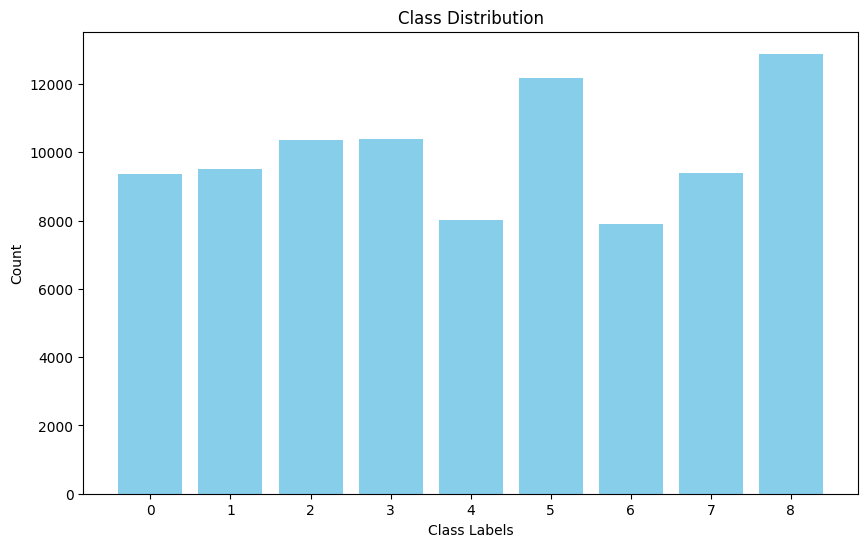

In [5]:
dataset = sum_up_dataset(data_flag=DataFlag.PATHMNIST, img_size=224, mode="train", download=True)

### Val set

Using downloaded and verified file: /home/dzban112/.medmnist/dermamnist_224.npz
DATASET DESCRIPTION:
The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.


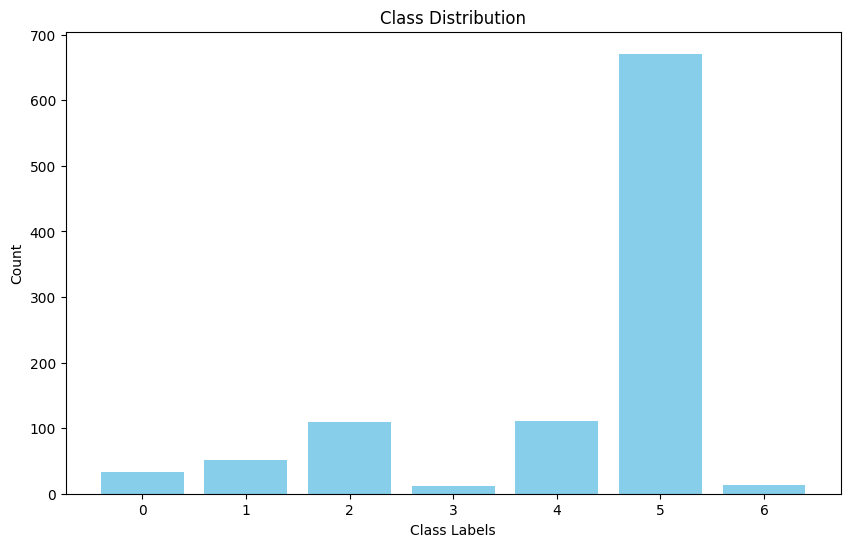

In [32]:
dataset = sum_up_dataset(data_flag=DataFlag.DERMAMNIST, img_size=224, mode="val", download=True)

### Test set

Using downloaded and verified file: /home/dzban112/.medmnist/dermamnist_224.npz
DATASET DESCRIPTION:
The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.


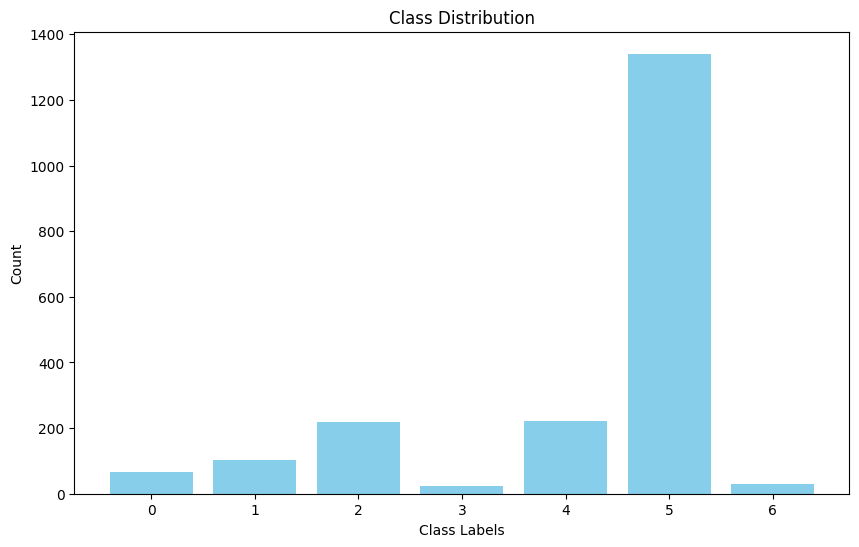

In [33]:
dataset = sum_up_dataset(data_flag=DataFlag.DERMAMNIST, img_size=224, mode="test", download=True)

## Examples visualization

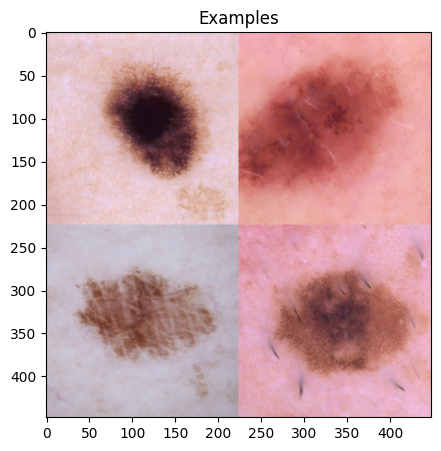

In [34]:
visualize(dataset)

## Trash

In [29]:
import torch
import pickle
from random import choice
from numpy import linspace
from torchvision.transforms import v2
import matplotlib.pyplot as plt

In [5]:
dataset[0]

(<PIL.Image.Image image mode=L size=224x224>, array([4]))

In [14]:
with open("/home/dzban112/MedMNIST/fitted_factors/organamnist.pkl", "rb") as file:
    factors = pickle.load(file)

In [15]:
factors

(tensor([0.4680]), tensor([0.2876]))

In [21]:
transforms_dict = {"ToImage": v2.ToImage(),
                           "DoDtype": v2.ToDtype(torch.float32, scale=True),
                           "Normalize": v2.Normalize(mean=factors[0], std=factors[1]),
                           "RandomAdjustSharpness": v2.RandomAdjustSharpness(sharpness_factor=choice(linspace(0.5, 1.5, 10)), p=0.5),
                           "ColorJitter": v2.ColorJitter(brightness=.2, hue=.2, contrast=.2, saturation=.2),
                           "RandomVerticalFlip": v2.RandomVerticalFlip(p=0.5),
                           "RandomHorizontalFlip": v2.RandomHorizontalFlip(p=0.5),
                           "RandomResizedCrop": v2.RandomResizedCrop(size=224, scale=(0.6, 1.0)),
                           "Resize": v2.Resize(size=[224, 224])
                           }

#train_transforms = v2.Compose([transforms_dict[key] for key in train_transforms])
eval_transforms = v2.Compose([transforms_dict[key] for key in ["ToImage", "DoDtype", "Normalize"]])

In [45]:
img, label = dataset[3]
new_img = eval_transforms(img)

In [46]:
img.size

(224, 224)

In [47]:
new_img.shape

torch.Size([1, 224, 224])

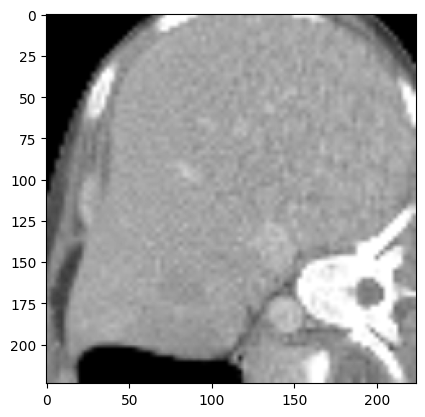

In [48]:
plt.imshow(torch.movedim(new_img, 0,2), cmap='gray')

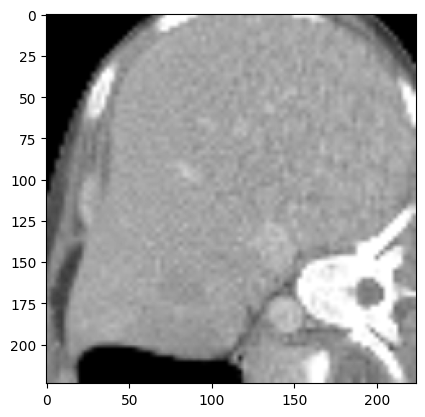

In [49]:
plt.imshow(img, cmap='gray')

In [59]:
transforms = v2.Compose([v2.PILToTensor(), v2.ToDtype(torch.float32, scale=True)])

img_stack=[]
for i in range(len(dataset)):
    img = transforms(dataset[i][0])
    img_stack.append(img)

In [60]:
img_stack = torch.stack(img_stack)

In [61]:
img_stack.shape

torch.Size([34561, 1, 224, 224])

In [62]:
torch.mean(img_stack, dim=(0,2,3))

tensor([0.4680])

In [64]:
torch.std(img_stack, dim=(0,2,3))

tensor([0.2876])

In [8]:
from typing import Union, List

In [9]:
## HYPERPARAMETERS:
MODEL_NR:int = 1
SAVE_TOP_CKPTS:int = 3
WANDB_PROJECT:str = "ORGANAMNIST"
MODEL_TYPE:Literal["dino_vits8", "dino_vitb8", "dino_vits16", "dino_vitb16"] = "dino_vits8"
DATA_FLAG:DataFlag = DataFlag.ORGANAMNIST
IMG_SIZE:Literal[28,64,128,224] = 224
TRAINABLE_LAYERS:Union[int, Literal["all"]] = "all"
EPOCHS:int = 20
BATCH_SIZE:int = 31
MAX_LR:float = 3e-4

LR_SCHEDULE:Literal["fixed", "plateau", "one_cycle"] = "one_cycle"
## If LR_SCHEDULE == "plateau":
PATIENCE:int = 5
## If LR_SCHEDULE == "fixed":
MILESTONES:List[int] = [3, 6, 8, 9]
GAMMA:float = 0.1
## If LR_SCHEDULE == "one_cycle":
LR_ANNEAL_STRATEGY:Literal["linear", "cos"] = "cos"
INIT_DIV_FACTOR:int = 50
FINAL_DIV_FACTOR:int = 10000
PCT_START:float = 0.15

ACCUMULATE_GRAD_BATCHES:int = 3
DEVICES:int = 4
SELECTED_TRAIN_TRANSFORMS:List[str] = ["ToImage","DoDtype", "RandomVerticalFlip","RandomHorizontalFlip","RandomResizedCrop", "Normalize"]
BCKB_DROPOUT:float = 0.12
NUM_WORKERS:int = 4

In [69]:
from dino_model import DINO_Model

In [10]:
LR_PARAMS={
    "patience": PATIENCE,
    "milestones": MILESTONES,
    "gamma": GAMMA,
    "lr_anneal_strategy": LR_ANNEAL_STRATEGY,
    "init_div_factor": INIT_DIV_FACTOR,
    "final_div_factor": FINAL_DIV_FACTOR,
    "pct_start": PCT_START
}

In [11]:
model = DINO_Model(
        model_type=MODEL_TYPE,
        dataset_name=DATA_FLAG,
        trainable_layers=TRAINABLE_LAYERS,
        backbone_dropout=BCKB_DROPOUT,
        max_lr=MAX_LR,
        lr_schedule=LR_SCHEDULE,
        lr_params=LR_PARAMS
    )

Using downloaded and verified file: /home/dzban112/.medmnist/organamnist.npz


In [13]:
vars(model.criterion)

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict([('weight',
               tensor([17.6692, 24.8640, 25.4687, 23.4471,  8.7209,  9.0545,  5.6069,  8.8188,
                        8.7964, 11.4025,  9.7054]))]),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict(),
 'reduction': 'mean',
 'ignore_index': -100,
 'label_smoothing': 0.0}

In [76]:
state_dict = model.state_dict()

In [78]:
state_dict['backbone.patch_embed.proj.weight'].shape

torch.Size([384, 1, 8, 8])